In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA                #principal component analysis
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from matplotlib import animation
from sklearn.preprocessing import RobustScaler
from copy import deepcopy
from sklearn.decomposition import KernelPCA
import seaborn as sns
import sys
from io import StringIO
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import xgboost as xgb
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
qso_wise_ukidss = pd.read_csv("qso_wise_ukidss.csv")

In [ ]:
len(qso_wise_ukidss[qso_wise_ukidss["redshift"]>0])

In [ ]:
qso_wise_ukidss.isnull().sum()

In [4]:
qso_wise_ukidss = qso_wise_ukidss[qso_wise_ukidss["redshift"]<5]
qso_wise_ukidss["redshift"].describe()

count    153471.000000
mean          1.537542
std           0.825073
min           0.013172
25%           0.876841
50%           1.443436
75%           2.155602
max           4.985539
Name: redshift, dtype: float64

In [5]:
nan_value = float("NaN")
qso_wise_ukidss.replace("", nan_value, inplace=True)
qso_wise_ukidss.dropna(subset = ["u"], inplace=True)
qso_wise_ukidss.dropna(subset = ["g"], inplace=True)
qso_wise_ukidss.dropna(subset = ["r"], inplace=True)
qso_wise_ukidss.dropna(subset = ["i"], inplace=True)
qso_wise_ukidss.dropna(subset = ["z"], inplace=True)
qso_wise_ukidss.dropna(subset = ["W1mag"], inplace=True)
qso_wise_ukidss.dropna(subset = ["W2mag"], inplace=True)
qso_wise_ukidss.dropna(subset = ["W3mag"], inplace=True)
qso_wise_ukidss.dropna(subset = ["W4mag"], inplace=True)
qso_wise_ukidss.dropna(subset = ["y"], inplace=True)
qso_wise_ukidss.dropna(subset = ["j"], inplace=True)
qso_wise_ukidss.dropna(subset = ["h"], inplace=True)
qso_wise_ukidss.dropna(subset = ["k"], inplace=True)

In [6]:
qso_wise_ukidss["ug"]= qso_wise_ukidss["u"]-qso_wise_ukidss["g"]
qso_wise_ukidss["ur"]= qso_wise_ukidss["u"]-qso_wise_ukidss["r"]
qso_wise_ukidss["ui"]= qso_wise_ukidss["u"]-qso_wise_ukidss["i"]
qso_wise_ukidss["uz"]= qso_wise_ukidss["u"]-qso_wise_ukidss["z"]
qso_wise_ukidss["gr"]= qso_wise_ukidss["g"]-qso_wise_ukidss["r"]
qso_wise_ukidss["gi"]= qso_wise_ukidss["g"]-qso_wise_ukidss["i"]
qso_wise_ukidss["gz"]= qso_wise_ukidss["g"]-qso_wise_ukidss["z"]
qso_wise_ukidss["ri"]= qso_wise_ukidss["r"]-qso_wise_ukidss["i"]
qso_wise_ukidss["rz"]= qso_wise_ukidss["r"]-qso_wise_ukidss["z"]
qso_wise_ukidss["iz"]= qso_wise_ukidss["i"]-qso_wise_ukidss["z"]
qso_wise_ukidss["W1W2"]= qso_wise_ukidss["W1mag"]-qso_wise_ukidss["W2mag"]
qso_wise_ukidss["W1W3"]= qso_wise_ukidss["W1mag"]-qso_wise_ukidss["W3mag"]
qso_wise_ukidss["W1W4"]= qso_wise_ukidss["W1mag"]-qso_wise_ukidss["W4mag"]
qso_wise_ukidss["W2W3"]= qso_wise_ukidss["W2mag"]-qso_wise_ukidss["W3mag"]
qso_wise_ukidss["W2W4"]= qso_wise_ukidss["W2mag"]-qso_wise_ukidss["W4mag"]
qso_wise_ukidss["W3W4"]= qso_wise_ukidss["W3mag"]-qso_wise_ukidss["W4mag"]
qso_wise_ukidss["YJ"]= qso_wise_ukidss["y"]-qso_wise_ukidss["j"]
qso_wise_ukidss["YH"]= qso_wise_ukidss["y"]-qso_wise_ukidss["h"]
qso_wise_ukidss["YK"]= qso_wise_ukidss["y"]-qso_wise_ukidss["k"]
qso_wise_ukidss["JH"]= qso_wise_ukidss["j"]-qso_wise_ukidss["h"]
qso_wise_ukidss["JK"]= qso_wise_ukidss["j"]-qso_wise_ukidss["k"]
qso_wise_ukidss["HK"]= qso_wise_ukidss["h"]-qso_wise_ukidss["k"]
qso_wise_ukidss["iY"]= qso_wise_ukidss["i"]-qso_wise_ukidss["y"]

In [7]:
X=qso_wise_ukidss[["u","g","r","i","z","ug","ur","ui","uz","gr","gi","gz","ri","rz","iz","W1mag","W2mag","W3mag","W4mag","W1W2","W1W3","W1W4","W2W3","W2W4",
                         "W3W4","j","h","y","k","YJ","YH","YK","JH","JK","HK","iY"]]  # Features from feature importance
y=qso_wise_ukidss['redshift']

# X=qso_wise_ukidss[["z","ug","gr","ri","rz","W1mag","W1W2","W1W3","W2W3","y","YH","YK"]]  # Features from feature importance
# y=qso_wise_ukidss['redshift']

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
X.shape

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# x_train_new = scaler.fit_transform(x_train)
# x_test_new = scaler.fit_transform(x_test)
x_train = (x_train-x_train.mean())/x_train.std()

# X has 36 dimensions/features meaning that a regression model should make a function:
# $y$ = $\beta_0 +\beta_1x_1+\beta_2x_2+...+\beta_{36}x_{36}$
# Now the assumption is that there could be a linear relation between these 36 dimentions and an extra dimension with the redshift


In [ ]:
model = LinearRegression()

In [ ]:
model.fit(x_train, y_train)

In [ ]:
r_sq = model.score(x_train, y_train)
>>> print(f"coefficient of determination: {r_sq}")

In [ ]:
print(f"intercept: {model.intercept_}")
print(f"coefficients: {model.coef_}")

In [ ]:
y_pred = model.predict(x_train)
y_pred_test = model.predict(x_test)

In [ ]:
from sklearn import metrics

## Errors on the train data

In [ ]:
print(metrics.mean_absolute_error(y_train,y_pred))
print(metrics.mean_squared_error(y_train,y_pred))
print(np.sqrt(metrics.mean_absolute_error(y_train,y_pred)))

## Errors on the test data

In [ ]:
print(metrics.mean_absolute_error(y_test,y_pred_test))
print(metrics.mean_squared_error(y_test,y_pred_test))
print(np.sqrt(metrics.mean_absolute_error(y_test,y_pred_test)))

In [ ]:
plt.figure(figsize=(10,8))
x=[0,1,2,3,4,5]
y=[]
for i in[0,1,2,3,4,5]:
    yval=x[i]
    y.append(yval)
plt.scatter(y_pred_test,y_test,color="purple")
plt.plot(x,y,color="red")
plt.xlim(-1,7)
plt.ylim(-0.2,7)

ax=plt.axes()
ax.set_xlabel("redshift (Simple Linear Regression)",fontsize=25)
ax.set_ylabel("redshift (SDSS DR16)",fontsize=25)
ax.tick_params(axis="x",colors="k",labelsize=20)
ax.tick_params(axis="y",colors="k",labelsize=20)
plt.annotate("rms error: 0.6", (3.2,2),fontsize=30,color="k")
plt.legend(markerscale=3,fontsize=20);

In [ ]:
y_test.describe()

### Polynomial regression

In [ ]:
poly_features = poly.fit_transform(X)

poly_features

In [ ]:
X.values.shape

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features_x = poly.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(poly_features_x, y, test_size = 0.2, random_state = 42)


poly_reg_model = LinearRegression()
poly_reg_model.fit(x_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
poly_reg_y_predicted = poly_reg_model.predict(x_test)
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted))
poly_reg_rmse

In [ ]:
from sklearn.metrics import mean_squared_error
poly_reg_y_predicted = poly_reg_model.predict(x_train)
poly_reg_rmse = np.sqrt(mean_squared_error(y_train, poly_reg_y_predicted))
print("rmse on train data",poly_reg_rmse)

In [ ]:
plt.figure(figsize=(10,8))
x=[0,1,2,3,4]
y=[]
for i in[0,1,2,3,4]:
    yval=x[i]
    y.append(yval)
plt.scatter(poly_reg_y_predicted,y_train)
plt.plot(x,y,color="red")
ax=plt.axes()
ax.set_xlabel("Pred redshift",fontsize=20)
ax.set_ylabel("Spec redshift",fontsize=20)
ax.tick_params(axis="x",colors="k",labelsize=15)
ax.tick_params(axis="y",colors="k",labelsize=15)
plt.legend();

In [9]:
import xgboost
from xgboost import XGBRegressor
xgb_r = xgboost.XGBRegressor(objective ='reg:squarederror', min_child_weight=1,
                  max_depth=9, n_estimators = 200, seed = 42,eval_metric="rmsle")

In [9]:
xgb_r.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [ ]:
filename = 'regression_sdss_wise_ukidss.sav'
pickle.dump(xgb_r, open(filename, 'wb'))

In [10]:
xgb_r = pickle.load(open("./regression_sdss_wise_ukidss.sav", 'rb'))


In [ ]:
# print(f"intercept: {xgb_r.intercept_}")
# print(f"coefficients: {xgb_r.coef_}")

In [11]:
pred = xgb_r.predict(x_test)
pred_train = xgb_r.predict(x_train)

In [12]:
from sklearn.metrics import mean_squared_error as MSE
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))
rmse_train = np.sqrt(MSE(y_train, pred_train))
print("RMSE on train: % f" %(rmse_train))

RMSE :  0.221275
RMSE on train:  0.129091


In [22]:
np.square(np.mean(np.square(((y_test-pred)/y_test))))*100

9.529987972154197

C:\Users\magei\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


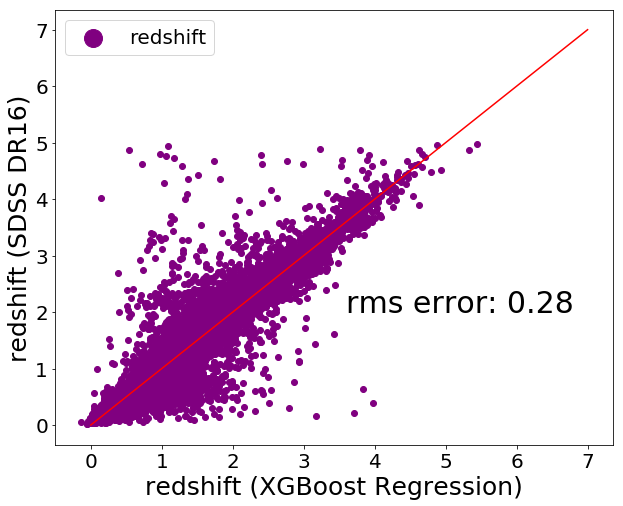

In [13]:
plt.figure(figsize=(10,8))
x=[0,1,2,3,4,5,6,7]
y=[]
for i in[0,1,2,3,4,5,6,7]:
    yval=x[i]
    y.append(yval)
plt.scatter(pred,y_test,color="purple")
plt.plot(x,y,color="red")


ax=plt.axes()
ax.set_xlabel("redshift (XGBoost Regression)",fontsize=25)
ax.set_ylabel("redshift (SDSS DR16)",fontsize=25)
ax.tick_params(axis="x",colors="k",labelsize=20)
ax.tick_params(axis="y",colors="k",labelsize=20)
plt.annotate("rms error: 0.28", (3.6,2),fontsize=30,color="k")
plt.savefig("reg.png",dpi=200)
plt.legend(markerscale=3,fontsize=20);

In [ ]:
plt.figure(figsize=(10,8))
x=[0,1,2,3,4]
y=[]
for i in[0,1,2,3,4]:
    yval=x[i]
    y.append(yval)
plt.scatter(pred_train,y_train)
plt.plot(x,y,color="red")
ax=plt.axes()
ax.set_xlabel("Pred redshift",fontsize=20)
ax.set_ylabel("Spec redshift",fontsize=20)
ax.tick_params(axis="x",colors="k",labelsize=15)
ax.tick_params(axis="y",colors="k",labelsize=15)
plt.legend();

In [ ]:
feature_important = xgb_r.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score")
data.nsmallest(40, columns="score").plot(kind='barh', figsize = (30,15)) ## plot top 40 features
ax=plt.axes()

ax.tick_params(axis="x",colors="k",labelsize=30)
ax.tick_params(axis="y",colors="k",labelsize=30)
plt.legend(fontsize=30,markerscale=30)
plt.savefig('fi_gaia.png')

# Making redshift predictions for gaia dataset 40 < b < 90 

In [14]:
cand9070 = pd.read_csv("9070_wise_ukidss_sdss.csv")
cand7060 = pd.read_csv("7060_wise_ukidss_sdss.csv")
cand6050 = pd.read_csv("6050_wise_ukidss_sdss.csv")
cand5040 = pd.read_csv("5040_wise_ukidss_sdss.csv")

In [15]:
cand =pd.concat([cand9070,cand7060,cand6050,cand5040],axis=0)

In [ ]:
cand

In [ ]:
len(cand6050)

In [16]:
test = cand.drop_duplicates(subset="ra")

In [17]:
len(test)

69030

In [18]:
nan_value = float("NaN")
test.replace("", nan_value, inplace=True)
test.dropna(subset = ["umag"], inplace=True)
test.dropna(subset = ["gmag"], inplace=True)
test.dropna(subset = ["rmag"], inplace=True)
test.dropna(subset = ["imag"], inplace=True)
test.dropna(subset = ["zmag"], inplace=True)
test.dropna(subset = ["W1mag"], inplace=True)
test.dropna(subset = ["W2mag"], inplace=True)
test.dropna(subset = ["W3mag"], inplace=True)
test.dropna(subset = ["W4mag"], inplace=True)
test.dropna(subset = ["yAperMag3"], inplace=True)
test.dropna(subset = ["j_1AperMag3"], inplace=True)
test.dropna(subset = ["hAperMag3"], inplace=True)
test.dropna(subset = ["kAperMag3"], inplace=True)

C:\Users\magei\anaconda3\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-18-d00c6455e3be>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(subset = ["umag"], inplace=True)
<ipython-input-18-d00c6455e3be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(subset = ["gmag"], inplace=True)
<ipython-input-18-d00c6455e3be>:5: SettingWithC

In [19]:
test["ug"]=   test["umag"]-test["gmag"]
test["ur"]=   test["umag"]-test["rmag"]
test["ui"]=   test["umag"]-test["imag"]
test["uz"]=   test["umag"]-test["zmag"]
test["gr"]=   test["gmag"]-test["rmag"]
test["gi"]=   test["gmag"]-test["imag"]
test["gz"]=   test["gmag"]-test["zmag"]
test["ri"]=   test["rmag"]-test["imag"]
test["rz"]=   test["rmag"]-test["zmag"]
test["iz"]=   test["imag"]-test["zmag"]
test["W1W2"]= test["W1mag"]-test["W2mag"]
test["W1W3"]= test["W1mag"]-test["W3mag"]
test["W1W4"]= test["W1mag"]-test["W4mag"]
test["W2W3"]= test["W2mag"]-test["W3mag"]
test["W2W4"]= test["W2mag"]-test["W4mag"]
test["W3W4"]= test["W3mag"]-test["W4mag"]
test["YJ"]=   test["yAperMag3"]-test["j_1AperMag3"]
test["YH"]=   test["yAperMag3"]-test["hAperMag3"]
test["YK"]=   test["yAperMag3"]-test["kAperMag3"]
test["JH"]=   test["j_1AperMag3"]-test["hAperMag3"]
test["JK"]=   test["j_1AperMag3"]-test["kAperMag3"]
test["HK"]=   test["hAperMag3"]-test["kAperMag3"]
test["iY"]=   test["imag"]-test["yAperMag3"]

<ipython-input-19-cf507b012806>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["ug"]=   test["umag"]-test["gmag"]
<ipython-input-19-cf507b012806>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["ur"]=   test["umag"]-test["rmag"]
<ipython-input-19-cf507b012806>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [20]:
X_test=test[["umag","gmag","rmag","imag","zmag","ug","ur","ui","uz","gr","gi","gz","ri","rz","iz","W1mag","W2mag","W3mag","W4mag","W1W2","W1W3","W1W4","W2W3","W2W4",
                         "W3W4","j_1AperMag3","hAperMag3","yAperMag3","kAperMag3","YJ","YH","YK","JH","JK","HK","iY"]]  # Features from feature importance

In [21]:
pred_test = xgb_r.predict(X_test)

In [22]:
pred_test_df = pd.DataFrame(pred_test)

In [23]:
pred_test_df.describe()

,0
count,57199.000000
mean,1.883599
std,0.936714
min,-0.142411
25%,1.146380
50%,1.771403
75%,2.754067
max,4.887864


In [24]:
test["redshift_prediction"] = pred_test

<ipython-input-24-eaaaaae414da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["redshift_prediction"] = pred_test


In [92]:
pd.set_option('display.max_columns', None)
len(test[(test["redshift_prediction"]>4) & (test["spCl"]=="QSO") & (test["class"]==1)])

42

In [94]:
len(test[(test["redshift_prediction"]>4) & (test["class"]==1)])

78

In [99]:
test[(test["class"]==2)&(test["spCl"]=="GALAXY")]

,angDist,angDist.1,angDist.2,col1,ra,dec,parallax,parallax_error,parallax_over_error,pm,pmra_error,pmdec_error,ruwe,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bg,br,gr_gaia,pm_error,pm_over_error,pred,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,eePA,W1mag,W2mag,W3mag,W4mag,Jmag,Hmag,Kmag,e_W1mag,e_W2mag,e_W3mag,e_W4mag,e_Jmag,e_Hmag,e_Kmag,ID,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,JName,ra.1,dec.1,yAperMag3,j_1AperMag3,hAperMag3,kAperMag3,yAperMag3Err,j_1AperMag3Err,hAperMag3Err,kAperMag3Err,sourceID,mode,epoch,mergedClass,objID,RA_ICRS,DE_ICRS,errHalfMaj,errHalfMin,errPosAng,mode.1,class,clean,e_RA_ICRS,e_DE_ICRS,umag,gmag,rmag,imag,zmag,e_umag,e_gmag,e_rmag,e_imag,e_zmag,zsp,e_zsp,f_zsp,spCl,subCl,pmRA.1,pmDE.1,e_pmRA.1,e_pmDE.1,sigRA,sigDE,zph,e_zph,<zph>,Q,SDSS16,Sp-ID,MJD,ug,ur,ui,uz,gr,gi,gz,ri,rz,iz,W1W2,W1W3,W1W4,W2W3,W2W4,W3W4,YJ,YH,YK,JH,JK,HK,iY,redshift_prediction
284,0.041455,0.142463,1.070710,282.0,201.965132,33.110574,-0.190170,0.316792,-0.600297,0.381030,0.260336,0.178559,1.164716,19.238527,18.738022,17.669596,-0.500505,1.068426,1.568931,0.315687,1.206985,1.0,J132751.54+330638.2,201.964785,33.110637,0.0534,0.0524,159.8,14.155,13.561,10.016,7.518,16.180,15.400,14.872,0.027,0.032,0.053,0.149,0.110,0.110,0.099,2.015133e+18,0000,0.0,0000,AAAB,151.00,87.00,67.00,303.00,0.351,J132751.64+330638.1,201.965176,33.110588,17.243,16.711,16.535,15.359,0.014,0.015,0.033,0.017,4.337927e+11,1,2010.2806,1.0,1237665127476428926,201.965126,33.110584,0.005,0.005,90,1.0,2,1,0.005,0.005,19.686,18.543,18.080,17.945,17.521,0.041,0.008,0.008,0.009,0.019,0.14117,0.00001,0.0,GALAXY,AGN,12.49,-2.25,2.55,2.55,414.38,72.52,0.1078,0.0502,0.1298,3,SDSS J132751.63+330638.1,2112-53534-0582,53111.3470,1.143,1.606,1.741,2.165,0.463,0.598,1.022,0.135,0.559,0.424,0.594,4.139,6.637,3.545,6.043,2.498,0.532,0.708,1.884,0.176,1.352,1.176,0.702,1.927615
1704,0.025105,0.066638,0.030836,1733.0,202.610505,24.255979,-0.072072,0.530381,-0.135887,0.770773,0.576979,0.292321,1.106418,19.992071,19.965101,18.683323,-0.026970,1.281778,1.308748,0.646805,1.191663,1.0,J133026.52+241521.5,202.610513,24.255983,0.0713,0.0677,7.2,14.665,14.255,12.515,8.953,NaN,NaN,NaN,0.031,0.045,0.440,NaN,NaN,NaN,NaN,2.031124e+18,0000,0.0,01nn,AACU,33.00,148.00,-76.00,160.00,NaN,J133026.52+241521.5,202.610522,24.255989,17.935,17.372,16.550,15.776,0.024,0.021,0.021,0.018,4.338016e+11,1,2010.1631,1.0,1237667447810621628,202.610511,24.255983,0.008,0.008,0,1.0,2,1,0.008,0.008,20.238,19.813,19.208,18.737,18.427,0.049,0.015,0.013,0.012,0.035,0.46268,0.00014,0.0,GALAXY,NaN,-0.79,-0.41,3.20,3.20,109.41,98.30,0.4690,0.1226,0.4127,3,SDSS J133026.52+241521.5,2665-54232-0387,53388.5203,0.425,1.030,1.501,1.811,0.605,1.076,1.386,0.471,0.781,0.310,0.410,2.150,5.712,1.740,5.302,3.562,0.563,1.385,2.159,0.822,1.596,0.774,0.802,0.489994
5359,0.098493,0.185855,0.112845,5495.0,195.265498,34.193487,-0.304036,0.618100,-0.491887,0.368718,0.460800,0.350176,1.224166,19.715395,19.293022,18.095457,-0.422373,1.197565,1.619938,0.578758,0.637086,1.0,J130103.72+341136.6,195.265533,34.193500,0.0573,0.0551,169.7,14.415,13.580,10.623,8.714,16.531,16.028,14.882,0.028,0.032,0.078,0.387,0.111,0.162,0.103,1.955135e+18,0000,0.0,110n,AAAC,-48.00,157.00,28.00,162.00,0.114,J130103.73+341136.6,195.265555,34.193509,17.610,17.023,16.193,15.367,0.026,0.028,0.018,0.016,4.337923e+11,1,2010.3134,1.0,1237665128010809424,195.265486,34.193462,0.006,0.006,90,1.0,2,1,0.006,0.006,19.430,18.959,18.257,17.880,17.604,0.039,0.011,0.009,0.009,0.025,0.23896,0.00002,0.0,GALAXY,STARFORMING,-2.39,1.68,2.64,2.64,49.23,125.26,0.2792,0.0398,0.2535,3,SDSS J130103.71+341136.4,2006-53476-0464,53111.3312,0.471,1.173,1.550,1.826,0.702,1.079,1.355,0.377,0.653,0.276,0.835,3.792,5.701,2.957,4.866,1.909,0.587,1.417,2.243,0.830,1.656,0.826,0.270,0.265718
6370,0.039853,0.117248,0.119829,6326.0,197.560660,32.717850,0.189117,0.152490,1.240188,0.181440,0.138777,0.105138,1.019120,18.501284,18.828173,17.984688,0.326889,0.843485,0.516596,0.174106,1.042124,1.0,J131014.

In [ ]:
#test.to_csv("GAIA5040_regression.csv")

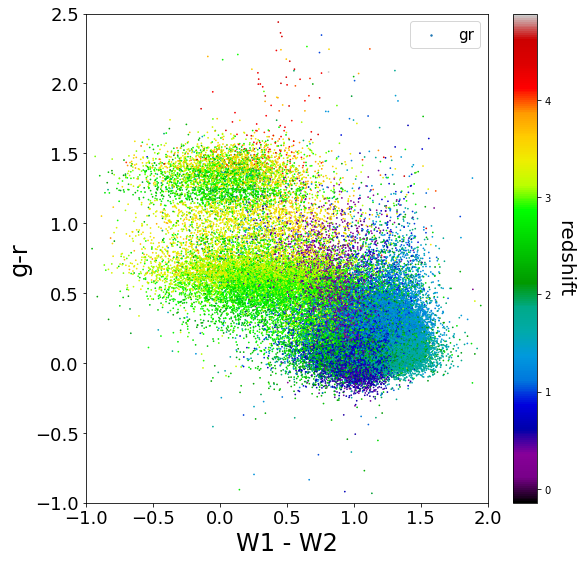

In [28]:
from matplotlib import pyplot as plt
plt.figure(figsize = (9,9))
graph = plt.scatter( test['W1W2'],test['gr'], s = 0.5, c = test['redshift_prediction'],cmap = plt.cm.nipy_spectral)


plt.xlim(-1,2)
plt.ylim(-1,2.5)
#plt.title('Targets for observations')
cb=plt.colorbar(graph)
cb.set_label('redshift', fontsize =20, rotation =-90, va='bottom')
ax = plt.axes()
ax.set_xlabel('W1 - W2', fontsize = 24)      
ax.set_ylabel('g-r', fontsize = 24)
ax.tick_params(axis='x', colors='k', labelsize=18)
ax.tick_params(axis='y', colors='k', labelsize=18)
plt.legend(fontsize = 15,markerscale=2)
#plt.savefig('targets_pm_qsos'+'.png', bbox_inches='tight', figsize=(5,5))

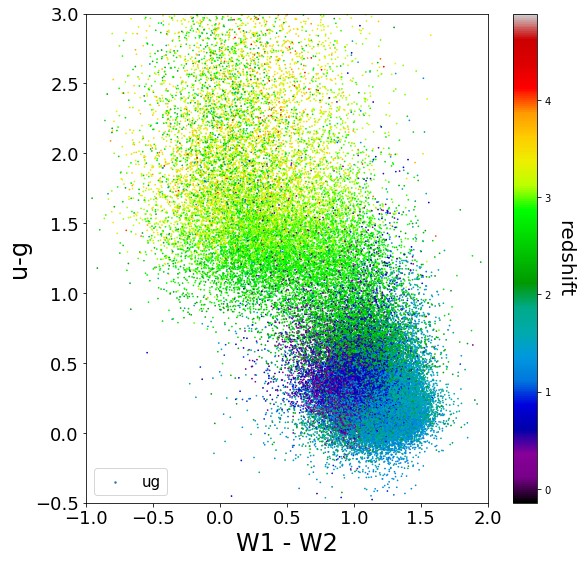

In [31]:
from matplotlib import pyplot as plt
plt.figure(figsize = (9,9))
graph = plt.scatter( test['W1W2'],test['ug'], s = 0.5, c = test['redshift_prediction'],cmap = plt.cm.nipy_spectral)


plt.xlim(-1,2)
plt.ylim(-0.5,3)
#plt.title('Targets for observations')
cb=plt.colorbar(graph)
cb.set_label('redshift', fontsize =20, rotation =-90, va='bottom')
ax = plt.axes()
ax.set_xlabel('W1 - W2', fontsize = 24)      
ax.set_ylabel('u-g', fontsize = 24)
ax.tick_params(axis='x', colors='k', labelsize=18)
ax.tick_params(axis='y', colors='k', labelsize=18)
plt.legend(fontsize = 15,markerscale=2)
#plt.savefig('targets_pm_qsos'+'.png', bbox_inches='tight', figsize=(5,5))

In [235]:
test2 = test[test["class"]==1]

In [110]:
test["JKab"] = test["JK"]+1.2483 - 2.2010

<ipython-input-110-44135dc4221a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["JKab"] = test["JK"]+1.2483 - 2.2010


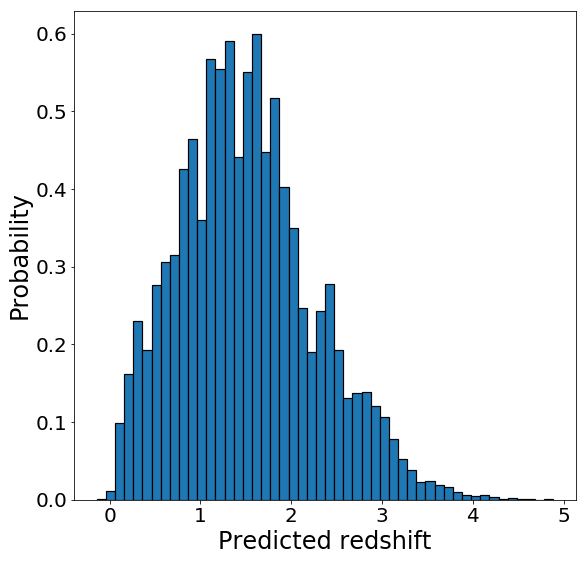

In [268]:
plt.figure(figsize = (9,9))

plt.hist(test2["redshift_prediction"], density=True, bins=50,edgecolor='black', linewidth=1.2)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('redshift')
ax = plt.axes()
ax.set_xlabel('Predicted redshift', fontsize = 24)      
ax.set_ylabel('Probability', fontsize = 24)
ax.tick_params(axis='x', colors='k', labelsize=20)
ax.tick_params(axis='y', colors='k', labelsize=20)
plt.savefig("hist_redshift_preds.png",dpi=200, figsize=(5,5))

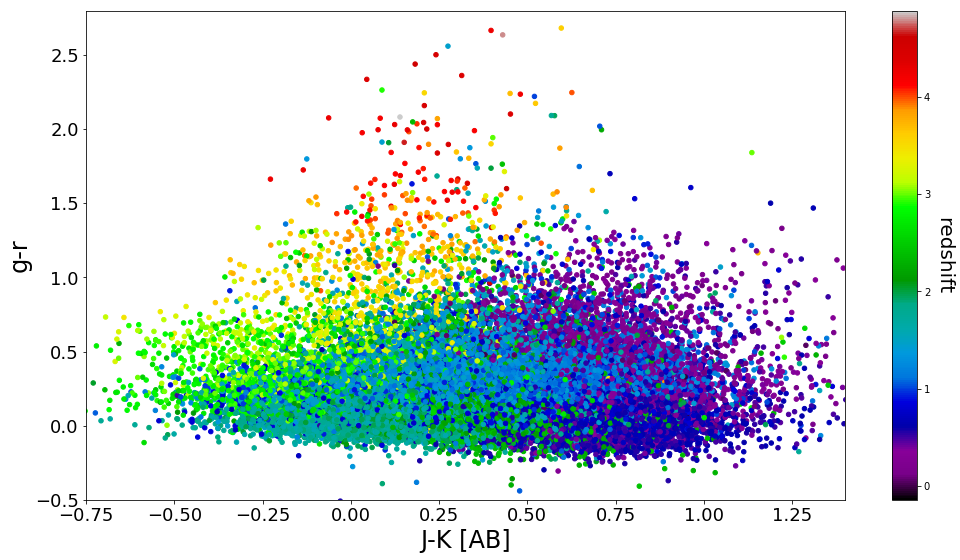

In [254]:
from matplotlib import pyplot as plt
# x_list=[-3,-2,-1,0,1,2,3,4,5]
# y_list=[]
# for i in(0,1,2,3,4,5,6,7,8):
#     y=2.1*x_list[i]+0.7
#     y_list.append(y)
    

plt.figure(figsize = (17,9))
graph = plt.scatter( test2['JKab'],test2['gr'], s = 20, c = test2['redshift_prediction'],cmap = plt.cm.nipy_spectral)
#plt.scatter( test['JKab'][test["class"]==2],test['gr'][test["class"]==2], s = 10,color="r")
# plt.plot(x_list,y_list)
plt.xlim(-0.75,1.4)
plt.ylim(-0.5,2.8)
#plt.title('Targets for observations')
cb=plt.colorbar(graph)
cb.set_label('redshift', fontsize =20, rotation =-90, va='bottom')
ax = plt.axes()
ax.set_xlabel('J-K [AB]', fontsize = 24)      
ax.set_ylabel('g-r', fontsize = 24)
ax.tick_params(axis='x', colors='k', labelsize=18)
ax.tick_params(axis='y', colors='k', labelsize=18)
plt.savefig('qsoredshifts.png',dpi=200, bbox_inches='tight')

In [281]:
test2["redshift_prediction"].describe()

count    42296.000000
mean         1.512598
std          0.748900
min         -0.142411
25%          0.964587
50%          1.460064
75%          1.954004
max          4.887864
Name: redshift_prediction, dtype: float64

In [284]:
test2[(test2["redshift_prediction"]>3)]

,angDist,angDist.1,angDist.2,col1,ra,dec,parallax,parallax_error,parallax_over_error,pm,pmra_error,pmdec_error,ruwe,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bg,br,gr_gaia,pm_error,pm_over_error,pred,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,eePA,W1mag,W2mag,W3mag,W4mag,Jmag,Hmag,Kmag,e_W1mag,e_W2mag,e_W3mag,e_W4mag,e_Jmag,e_Hmag,e_Kmag,ID,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,JName,ra.1,dec.1,yAperMag3,j_1AperMag3,hAperMag3,kAperMag3,yAperMag3Err,j_1AperMag3Err,hAperMag3Err,kAperMag3Err,sourceID,mode,epoch,mergedClass,objID,RA_ICRS,DE_ICRS,errHalfMaj,errHalfMin,errPosAng,mode.1,class,clean,e_RA_ICRS,e_DE_ICRS,umag,gmag,rmag,imag,zmag,e_umag,e_gmag,e_rmag,e_imag,e_zmag,zsp,e_zsp,f_zsp,spCl,subCl,pmRA.1,pmDE.1,e_pmRA.1,e_pmDE.1,sigRA,sigDE,zph,e_zph,<zph>,Q,SDSS16,Sp-ID,MJD,ug,ur,ui,uz,gr,gi,gz,ri,rz,iz,W1W2,W1W3,W1W4,W2W3,W2W4,W3W4,YJ,YH,YK,JH,JK,HK,iY,redshift_prediction,JKab
262,0.045387,0.052172,0.173304,255.0,203.937319,26.553667,-0.181408,0.239893,-0.756204,0.608754,0.310586,0.151719,1.020538,19.178547,19.655134,18.587934,0.476587,1.067200,0.590613,0.345662,1.761124,1.0,J133544.96+263313.0,203.937354,26.553630,0.1216,0.1136,8.2,15.702,15.252,11.743,8.428,NaN,NaN,NaN,0.045,0.085,0.202,NaN,NaN,NaN,NaN,2.045127e+18,0000,0.0,0nnn,AABU,54.00,352.00,96.00,378.00,NaN,J133544.95+263313.2,203.937330,26.553678,18.209,17.713,17.287,16.664,0.034,0.038,0.049,0.043,4.337990e+11,1,2010.2288,-1.0,1237667443515326576,203.937308,26.553659,0.005,0.005,90,3.0,1,0,0.005,0.005,24.179,19.801,18.842,18.786,18.746,0.786,0.014,0.011,0.012,0.041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,SDSS J133544.95+263313.1,NaN,53388.4267,4.378,5.337,5.393,5.433,0.959,1.015,1.055,0.056,0.096,0.040,0.450,3.959,7.274,3.509,6.824,3.315,0.496,0.922,1.545,0.426,1.049,0.623,0.577,3.690354,0.0963
637,0.049690,0.173634,0.423185,623.0,202.386336,32.271193,-0.088173,0.460950,-0.191285,0.344705,0.356998,0.281654,1.053767,19.978388,20.463469,19.409788,0.485081,1.053681,0.568600,0.454727,0.758048,1.0,J132932.69+321616.6,202.386247,32.271283,0.1760,0.1620,9.2,16.455,15.837,11.812,8.408,NaN,NaN,NaN,0.063,0.116,0.227,0.425,NaN,NaN,NaN,2.029132e+18,0000,0.0,0nnn,ABBC,114.00,672.00,541.00,733.00,NaN,J132932.72+321616.4,202.386351,32.271239,19.303,18.607,17.994,17.427,0.077,0.076,0.062,0.074,4.337933e+11,1,2010.1467,-1.0,1237665331469353151,202.386321,32.271187,0.024,0.021,90,1.0,1,1,0.024,0.021,24.319,20.671,20.052,19.872,19.759,1.130,0.027,0.026,0.035,0.111,3.23853,0.00043,0.0,QSO,BROADLINE,-20.98,-24.07,4.80,4.80,328.71,318.08,NaN,NaN,NaN,3,SDSS J132932.71+321616.2,6492-56362-0796,53137.3027,3.648,4.267,4.447,4.560,0.619,0.799,0.912,0.180,0.293,0.113,0.618,4.643,8.047,4.025,7.429,3.404,0.696,1.309,1.876,0.613,1.180,0.567,0.569,3.366597,0.2273
786,0.052409,0.049390,0.268123,866.0,200.864724,33.857067,0.114774,0.401738,0.285694,0.198179,0.394531,0.316323,1.029155,19.936260,20.328490,19.401980,0.392230,0.926510,0.534280,0.505682,0.391904,1.0,J132327.52+335125.1,200.864692,33.856997,0.2104,0.1916,13.2,16.678,16.082,12.312,9.411,NaN,NaN,NaN,0.071,0.148,0.292,NaN,NaN,NaN,NaN,2.015133e+18,0000,0.0,1nnn,ABBU,323.00,823.00,-672.00,895.00,NaN,J132327.53+335125.4,200.864740,33.857071,19.327,18.595,17.996,17.562,0.137,0.108,0.089,0.104,4.337924e+11,1,2010.3135,-1.0,1237665024910819904,200.864708,33.857062,0.011,0.011,0,1.0,1,1,0.011,0.011,22.909,20.647,19.866,19.794,19.700,0.364,0.024,0.019,0.023,0.075,3.54879,0.00052,0.0,QSO,BROADLINE,7.06,-19.36,3.46,3.46,94.72,493.95,NaN,NaN,NaN,3,SDSS J132327.52+335125.4,3982-55332-0478,53108.3133,2.262,3.043,3.115,3.209,0.781,0.853,0.947,0.072,0.166,0.094,0.596,4.366,7.267,3.770,6.671,2.901,0.732,1.331,1.765,0.599,1.033,0.434,0.467,3.564208,0.0803
798,0.034433,0.242374,0.069388,878.0,202.470271,31.903071,0.014453,0.284096,0.050873,0.230856,0.195232,0.174119,0.984486,19.107439,19.477304,18.372683,0.369865,1.104621,0.734756,0.261597,0.882486,1.0,J132952.86+315411.0,202.470251,31.903081,0.0545,0.0528,8.3,14.588,13.429,10.124,7.630

In [286]:
test2[(test2["redshift_prediction"]>3)  & (test2["spCl"]=="QSO")]

,angDist,angDist.1,angDist.2,col1,ra,dec,parallax,parallax_error,parallax_over_error,pm,pmra_error,pmdec_error,ruwe,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bg,br,gr_gaia,pm_error,pm_over_error,pred,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,eePA,W1mag,W2mag,W3mag,W4mag,Jmag,Hmag,Kmag,e_W1mag,e_W2mag,e_W3mag,e_W4mag,e_Jmag,e_Hmag,e_Kmag,ID,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,JName,ra.1,dec.1,yAperMag3,j_1AperMag3,hAperMag3,kAperMag3,yAperMag3Err,j_1AperMag3Err,hAperMag3Err,kAperMag3Err,sourceID,mode,epoch,mergedClass,objID,RA_ICRS,DE_ICRS,errHalfMaj,errHalfMin,errPosAng,mode.1,class,clean,e_RA_ICRS,e_DE_ICRS,umag,gmag,rmag,imag,zmag,e_umag,e_gmag,e_rmag,e_imag,e_zmag,zsp,e_zsp,f_zsp,spCl,subCl,pmRA.1,pmDE.1,e_pmRA.1,e_pmDE.1,sigRA,sigDE,zph,e_zph,<zph>,Q,SDSS16,Sp-ID,MJD,ug,ur,ui,uz,gr,gi,gz,ri,rz,iz,W1W2,W1W3,W1W4,W2W3,W2W4,W3W4,YJ,YH,YK,JH,JK,HK,iY,redshift_prediction,JKab
637,0.049690,0.173634,0.423185,623.0,202.386336,32.271193,-0.088173,0.460950,-0.191285,0.344705,0.356998,0.281654,1.053767,19.978388,20.463469,19.409788,0.485081,1.053681,0.568600,0.454727,0.758048,1.0,J132932.69+321616.6,202.386247,32.271283,0.1760,0.1620,9.2,16.455,15.837,11.812,8.408,NaN,NaN,NaN,0.063,0.116,0.227,0.425,NaN,NaN,NaN,2.029132e+18,0000,0.0,0nnn,ABBC,114.00,672.00,541.00,733.00,NaN,J132932.72+321616.4,202.386351,32.271239,19.303,18.607,17.994,17.427,0.077,0.076,0.062,0.074,4.337933e+11,1,2010.1467,-1.0,1237665331469353151,202.386321,32.271187,0.024,0.021,90,1.0,1,1,0.024,0.021,24.319,20.671,20.052,19.872,19.759,1.130,0.027,0.026,0.035,0.111,3.23853,0.00043,0.0,QSO,BROADLINE,-20.98,-24.07,4.80,4.80,328.71,318.08,NaN,NaN,NaN,3,SDSS J132932.71+321616.2,6492-56362-0796,53137.3027,3.648,4.267,4.447,4.560,0.619,0.799,0.912,0.180,0.293,0.113,0.618,4.643,8.047,4.025,7.429,3.404,0.696,1.309,1.876,0.613,1.180,0.567,0.569,3.366597,0.2273
786,0.052409,0.049390,0.268123,866.0,200.864724,33.857067,0.114774,0.401738,0.285694,0.198179,0.394531,0.316323,1.029155,19.936260,20.328490,19.401980,0.392230,0.926510,0.534280,0.505682,0.391904,1.0,J132327.52+335125.1,200.864692,33.856997,0.2104,0.1916,13.2,16.678,16.082,12.312,9.411,NaN,NaN,NaN,0.071,0.148,0.292,NaN,NaN,NaN,NaN,2.015133e+18,0000,0.0,1nnn,ABBU,323.00,823.00,-672.00,895.00,NaN,J132327.53+335125.4,200.864740,33.857071,19.327,18.595,17.996,17.562,0.137,0.108,0.089,0.104,4.337924e+11,1,2010.3135,-1.0,1237665024910819904,200.864708,33.857062,0.011,0.011,0,1.0,1,1,0.011,0.011,22.909,20.647,19.866,19.794,19.700,0.364,0.024,0.019,0.023,0.075,3.54879,0.00052,0.0,QSO,BROADLINE,7.06,-19.36,3.46,3.46,94.72,493.95,NaN,NaN,NaN,3,SDSS J132327.52+335125.4,3982-55332-0478,53108.3133,2.262,3.043,3.115,3.209,0.781,0.853,0.947,0.072,0.166,0.094,0.596,4.366,7.267,3.770,6.671,2.901,0.732,1.331,1.765,0.599,1.033,0.434,0.467,3.564208,0.0803
798,0.034433,0.242374,0.069388,878.0,202.470271,31.903071,0.014453,0.284096,0.050873,0.230856,0.195232,0.174119,0.984486,19.107439,19.477304,18.372683,0.369865,1.104621,0.734756,0.261597,0.882486,1.0,J132952.86+315411.0,202.470251,31.903081,0.0545,0.0528,8.3,14.588,13.429,10.124,7.630,NaN,NaN,NaN,0.029,0.029,0.056,0.143,NaN,NaN,NaN,2.029132e+18,0000,0.0,990n,AAAB,88.00,89.00,106.00,97.00,NaN,J132952.88+315411.1,202.470338,31.903106,18.655,17.982,17.227,16.201,0.049,0.050,0.034,0.026,4.337936e+11,1,2010.1467,-2.0,1237665330932547874,202.470260,31.903073,0.022,0.019,0,1.0,1,1,0.019,0.022,21.144,20.512,19.973,19.563,19.219,0.095,0.025,0.024,0.027,0.064,3.78874,0.00066,0.0,QSO,NaN,-0.09,-2.31,3.30,3.30,236.30,249.63,NaN,NaN,NaN,3,SDSS J132952.86+315411.0,6492-56362-0826,53137.3031,0.632,1.171,1.581,1.925,0.539,0.949,1.293,0.410,0.754,0.344,1.159,4.464,6.958,3.305,5.799,2.494,0.673,1.428,2.454,0.755,1.781,1.026,0.908,3.300095,0.8283
1101,0.074072,0.373782,0.356596,1104.0,201.923758,22.324026,0.180035,0.377140,0.477370,0.508311,0.444586,0.323583,1.005203,19.765358,20.105122,19.453833,0.339764,0.651289,0.311525,0.549875,0.924412,1.0,J132741.72+221926.6,201.923852,22.324072,0.1623,0.149

In [271]:
test2[test2["redshift_prediction"]>4]

,angDist,angDist.1,angDist.2,col1,ra,dec,parallax,parallax_error,parallax_over_error,pm,pmra_error,pmdec_error,ruwe,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bg,br,gr_gaia,pm_error,pm_over_error,pred,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,eePA,W1mag,W2mag,W3mag,W4mag,Jmag,Hmag,Kmag,e_W1mag,e_W2mag,e_W3mag,e_W4mag,e_Jmag,e_Hmag,e_Kmag,ID,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,JName,ra.1,dec.1,yAperMag3,j_1AperMag3,hAperMag3,kAperMag3,yAperMag3Err,j_1AperMag3Err,hAperMag3Err,kAperMag3Err,sourceID,mode,epoch,mergedClass,objID,RA_ICRS,DE_ICRS,errHalfMaj,errHalfMin,errPosAng,mode.1,class,clean,e_RA_ICRS,e_DE_ICRS,umag,gmag,rmag,imag,zmag,e_umag,e_gmag,e_rmag,e_imag,e_zmag,zsp,e_zsp,f_zsp,spCl,subCl,pmRA.1,pmDE.1,e_pmRA.1,e_pmDE.1,sigRA,sigDE,zph,e_zph,<zph>,Q,SDSS16,Sp-ID,MJD,ug,ur,ui,uz,gr,gi,gz,ri,rz,iz,W1W2,W1W3,W1W4,W2W3,W2W4,W3W4,YJ,YH,YK,JH,JK,HK,iY,redshift_prediction,JKab
3966,0.035484,0.098647,0.080008,4231.0,197.751485,33.991035,0.082401,0.372697,0.221095,0.465924,0.383157,0.294636,1.028604,19.782314,20.930573,18.775140,1.148259,2.155433,1.007174,0.483342,0.963962,1.0,J131100.36+335927.7,197.751512,33.991032,0.0637,0.0613,6.3,14.709,14.030,10.159,7.749,NaN,NaN,NaN,0.031,0.037,0.054,0.157,NaN,NaN,NaN,1.979133e+18,0000,0.0,000n,AAAB,100.00,245.00,-46.00,256.00,NaN,J131100.36+335927.7,197.751509,33.991054,17.820,17.087,16.404,15.693,0.032,0.027,0.022,0.021,4.337924e+11,1,2010.3134,-2.0,1237665128011727174,197.751473,33.991035,0.013,0.013,0,1.0,1,1,0.013,0.013,23.324,22.005,20.406,19.274,18.793,0.497,0.063,0.026,0.016,0.036,4.53832,0.00032,0.0,QSO,BROADLINE,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,3,SDSS J131100.35+335927.7,10253-58487-0731,53111.3370,1.319,2.918,4.050,4.531,1.599,2.731,3.212,1.132,1.613,0.481,0.679,4.550,6.960,3.871,6.281,2.410,0.733,1.416,2.127,0.683,1.394,0.711,1.454,4.613688,0.4413
6407,0.022967,0.183161,0.100377,6340.0,200.620671,27.585603,0.502690,0.373328,1.346508,0.353756,0.468578,0.308003,0.981406,19.521650,20.374940,18.653418,0.853290,1.721522,0.868232,0.560741,0.630871,1.0,J132228.95+273508.2,200.620658,27.585629,0.1364,0.1253,14.7,16.047,15.493,12.114,8.454,NaN,NaN,NaN,0.049,0.096,0.292,NaN,NaN,NaN,NaN,2.011127e+18,0000,0.0,0nnn,AABU,453.00,470.00,483.00,512.00,NaN,J132228.96+273508.3,200.620688,27.585652,18.479,18.028,17.520,16.961,0.038,0.041,0.044,0.050,4.337980e+11,1,2010.1191,-1.0,1237667324336799919,200.620676,27.585608,0.007,0.006,90,1.0,1,1,0.007,0.006,25.678,20.884,19.404,19.070,18.988,0.510,0.027,0.014,0.014,0.040,4.13098,-1.00000,0.0,QSO,NaN,-2.08,-5.68,4.34,4.34,40.65,161.59,NaN,NaN,NaN,3,SDSS J132228.96+273508.1,5997-56309-0926,53360.5116,4.794,6.274,6.608,6.690,1.480,1.814,1.896,0.334,0.416,0.082,0.554,3.933,7.593,3.379,7.039,3.660,0.451,0.959,1.518,0.508,1.067,0.559,0.591,4.287253,0.1143
8321,0.105409,0.009363,0.658165,8048.0,198.914852,29.411307,1.053099,0.452092,2.329391,0.370191,0.350937,0.309710,0.998586,19.958170,20.703812,19.005314,0.745642,1.698498,0.952856,0.468057,0.790911,1.0,J131539.53+292440.1,198.914747,29.411149,0.1631,0.1479,11.0,16.077,15.695,11.780,8.663,NaN,NaN,NaN,0.056,0.131,0.376,NaN,NaN,NaN,NaN,1.988129e+18,0000,0.0,1nnn,ABCU,62.00,548.00,-269.00,603.00,NaN,J131539.56+292440.6,198.914853,29.411305,18.646,18.242,17.676,17.175,0.045,0.054,0.063,0.067,4.337957e+11,1,2010.1414,-1.0,1237665442054209664,198.914867,29.411334,0.013,0.013,0,1.0,1,1,0.013,0.013,23.835,21.566,19.723,19.325,19.342,0.980,0.054,0.019,0.019,0.076,NaN,NaN,NaN,NaN,NaN,-1.15,4.55,5.09,5.09,243.68,155.41,NaN,NaN,NaN,3,SDSS J131539.56+292440.8,NaN,53148.2780,2.269,4.112,4.510,4.493,1.843,2.241,2.224,0.398,0.381,-0.017,0.382,4.297,7.414,3.915,7.032,3.117,0.404,0.970,1.471,0.566,1.067,0.501,0.679,4.145034,0.1143
10650,0.043847,0.280330,0.026874,9646.0,195.668214,23.315171,0.409720,0.423972,0.966385,0.947851,0.557374,0.572915,0.935200,19.470020,20.301884,18.608704,0.831864,1.693180,0.861316,0.799311,1.185835,1.0,J130240.36+231854.6,195.668206,23.315172,0.1248,0.1146,21.4,15.591,15.302,11.81

C:\Users\magei\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


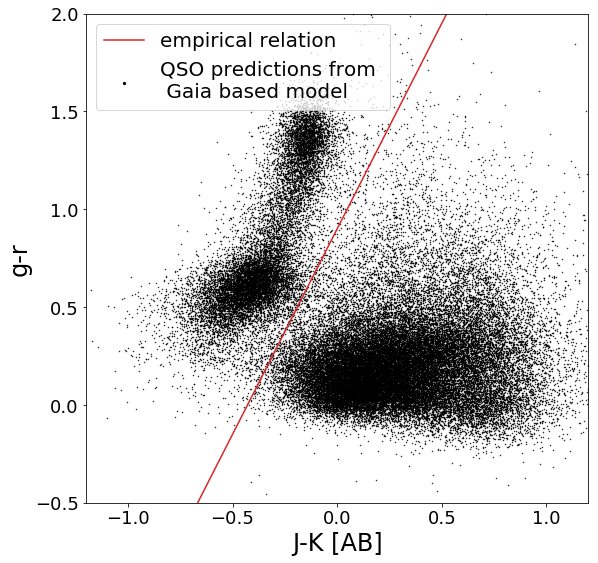

In [229]:
from matplotlib import pyplot as plt
x_list=[-3,-2,-1,0,1,2,3,4,5]
y_list=[]
for i in(0,1,2,3,4,5,6,7,8):
    y=2.1*x_list[i]+0.9
    y_list.append(y)
    

plt.figure(figsize = (9,9))
plt.plot(x_list,y_list,color="tab:red")

plt.scatter( test['JKab'],test['gr'], s = 0.2, color="k",label="")
#plt.scatter( test['JKab'][test["class"]==2],test['gr'][test["class"]==2], s = 10,color="r")
plt.xlim(-1.2,1.2)
plt.ylim(-0.5,2)
#plt.title('Targets for observations')

ax = plt.axes()
ax.set_xlabel('J-K [AB]', fontsize = 24)      
ax.set_ylabel('g-r', fontsize = 24)
ax.tick_params(axis='x', colors='k', labelsize=18)
ax.tick_params(axis='y', colors='k', labelsize=18)
plt.legend( ["empirical relation","QSO predictions from \n Gaia based model"], fontsize = 20,markerscale=5)
plt.savefig('oldmodel'+".png", bbox_inches='tight', figsize=(5,5))

In [166]:
snstars = (test["class"]==0) & (test["pm_over_error"]<2)
snstars

0        False
8        False
14       False
16       False
19       False
         ...  
90826    False
90827    False
90839     True
90845    False
90851    False
Length: 57199, dtype: bool

C:\Users\magei\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


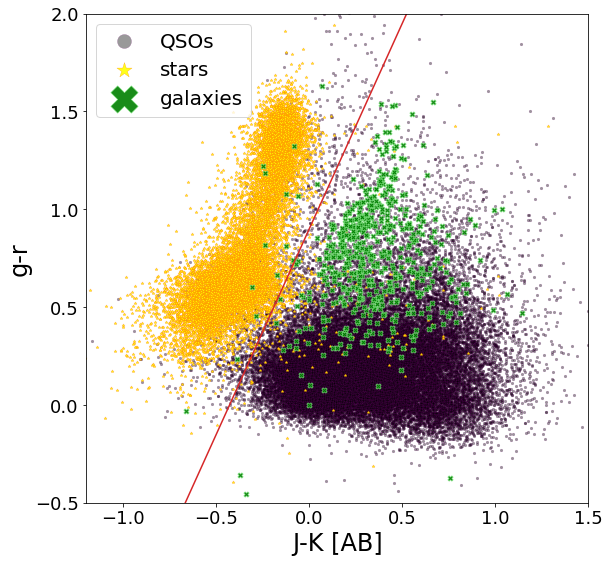

In [228]:
from matplotlib import pyplot as plt
x_list=[-3,-2,-1,0,1,2,3,4,5]
y_list=[]
for i in(0,1,2,3,4,5,6,7,8):
    y=2.1*x_list[i]+0.9
    y_list.append(y)
    

plt.figure(figsize = (9,9))
plt.scatter( test['JKab'][test["class"]==1],test['gr'][test["class"]==1], s = 8, color="k",label="QSOs",alpha=0.4, linewidth=0.3, edgecolor="purple")
plt.scatter( test['JKab'][test["class"]==0],test['gr'][test["class"]==0], s = 10,alpha=0.9,facecolor="yellow",linewidth=0.3,edgecolor="darkorange",label="stars",marker = "*")
plt.scatter( test['JKab'][test["class"]==2],test['gr'][test["class"]==2], s = 30,color="green",edgecolor="lightgreen",linewidth=0.6,marker="X",label="galaxies",alpha=0.9)

plt.plot(x_list,y_list,color="tab:red")
plt.xlim(-1.2,1.5)
plt.ylim(-0.5,2)
#plt.title('Targets for observations')

ax = plt.axes()
ax.set_xlabel('J-K [AB]', fontsize = 24)      
ax.set_ylabel('g-r', fontsize = 24)
ax.tick_params(axis='x', colors='k', labelsize=18)
ax.tick_params(axis='y', colors='k', labelsize=18)
plt.legend( fontsize = 20,markerscale=5)
plt.savefig('newmodel'+'.png', bbox_inches='tight', figsize=(5,5))

In [232]:
test[test["class"]==2]

,angDist,angDist.1,angDist.2,col1,ra,dec,parallax,parallax_error,parallax_over_error,pm,pmra_error,pmdec_error,ruwe,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bg,br,gr_gaia,pm_error,pm_over_error,pred,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,eePA,W1mag,W2mag,W3mag,W4mag,Jmag,Hmag,Kmag,e_W1mag,e_W2mag,e_W3mag,e_W4mag,e_Jmag,e_Hmag,e_Kmag,ID,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,JName,ra.1,dec.1,yAperMag3,j_1AperMag3,hAperMag3,kAperMag3,yAperMag3Err,j_1AperMag3Err,hAperMag3Err,kAperMag3Err,sourceID,mode,epoch,mergedClass,objID,RA_ICRS,DE_ICRS,errHalfMaj,errHalfMin,errPosAng,mode.1,class,clean,e_RA_ICRS,e_DE_ICRS,umag,gmag,rmag,imag,zmag,e_umag,e_gmag,e_rmag,e_imag,e_zmag,zsp,e_zsp,f_zsp,spCl,subCl,pmRA.1,pmDE.1,e_pmRA.1,e_pmDE.1,sigRA,sigDE,zph,e_zph,<zph>,Q,SDSS16,Sp-ID,MJD,ug,ur,ui,uz,gr,gi,gz,ri,rz,iz,W1W2,W1W3,W1W4,W2W3,W2W4,W3W4,YJ,YH,YK,JH,JK,HK,iY,redshift_prediction,JKab
185,0.016034,0.162621,0.051738,152.0,203.145723,31.422393,-0.822993,0.950994,-0.865403,1.246908,0.791652,0.557709,1.775017,19.970226,19.457594,17.859833,-0.512632,1.597761,2.110393,0.968376,1.287629,1.0,J133234.97+312520.5,203.145729,31.422380,0.0741,0.0704,12.8,14.908,14.547,12.479,9.119,16.441,16.094,15.130,0.031,0.050,NaN,NaN,0.110,0.164,0.104,2.029132e+18,0000,0.0,00nn,AAUU,122.00,180.00,-64.00,193.00,0.202,J133234.97+312520.7,203.145726,31.422438,17.288,16.638,15.933,15.294,0.014,0.012,0.014,0.015,4.337939e+11,1,2010.1440,1.0,1237665227312201823,203.145722,31.422389,0.007,0.007,0,3.0,2,0,0.007,0.007,21.466,19.671,18.390,17.946,17.673,0.155,0.015,0.009,0.008,0.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,SDSS J133234.97+312520.5,NaN,53120.3759,1.795,3.076,3.520,3.793,1.281,1.725,1.998,0.444,0.717,0.273,0.361,2.429,5.789,2.068,5.428,3.360,0.650,1.355,1.994,0.705,1.344,0.639,0.658,0.269903,0.3913
284,0.041455,0.142463,1.070710,282.0,201.965132,33.110574,-0.190170,0.316792,-0.600297,0.381030,0.260336,0.178559,1.164716,19.238527,18.738022,17.669596,-0.500505,1.068426,1.568931,0.315687,1.206985,1.0,J132751.54+330638.2,201.964785,33.110637,0.0534,0.0524,159.8,14.155,13.561,10.016,7.518,16.180,15.400,14.872,0.027,0.032,0.053,0.149,0.110,0.110,0.099,2.015133e+18,0000,0.0,0000,AAAB,151.00,87.00,67.00,303.00,0.351,J132751.64+330638.1,201.965176,33.110588,17.243,16.711,16.535,15.359,0.014,0.015,0.033,0.017,4.337927e+11,1,2010.2806,1.0,1237665127476428926,201.965126,33.110584,0.005,0.005,90,1.0,2,1,0.005,0.005,19.686,18.543,18.080,17.945,17.521,0.041,0.008,0.008,0.009,0.019,0.14117,0.00001,0.0,GALAXY,AGN,12.49,-2.25,2.55,2.55,414.38,72.52,0.1078,0.0502,0.1298,3,SDSS J132751.63+330638.1,2112-53534-0582,53111.3470,1.143,1.606,1.741,2.165,0.463,0.598,1.022,0.135,0.559,0.424,0.594,4.139,6.637,3.545,6.043,2.498,0.532,0.708,1.884,0.176,1.352,1.176,0.702,1.927615,0.3993
740,0.077535,0.050404,0.087610,822.0,198.660370,35.411220,0.395089,0.447148,0.883576,0.332784,0.248560,0.339333,1.083103,19.733547,19.334131,18.204714,-0.399416,1.129417,1.528833,0.420629,0.791157,1.0,J131438.49+352440.3,198.660396,35.411207,0.0709,0.0679,13.5,14.915,14.412,11.009,8.694,16.699,16.183,15.215,0.031,0.043,0.110,0.303,0.138,0.197,0.154,1.991135e+18,0000,0.0,000n,AABB,161.00,218.00,107.00,226.00,0.349,J131438.48+352440.3,198.660374,35.411206,17.692,17.085,16.305,15.445,0.024,0.024,0.032,0.019,4.337919e+11,1,2010.3654,1.0,1237665026520580249,198.660352,35.411205,0.008,0.008,0,3.0,2,0,0.008,0.008,19.870,19.253,18.503,18.237,17.961,0.048,0.012,0.009,0.010,0.027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,SDSS J131438.48+352440.3,NaN,53108.3079,0.617,1.367,1.633,1.909,0.750,1.016,1.292,0.266,0.542,0.276,0.503,3.906,6.221,3.403,5.718,2.315,0.607,1.387,2.247,0.780,1.640,0.860,0.545,0.484656,0.6873
831,0.059095,0.116248,0.104558,927.0,203.328952,29.907151,0.189020,0.389824,0.484884,1.129074,0.466840,0.226636,1.255646,19.252302,18.969236,17.892931,-0.283066,1.076305,1.359371,0.518945,2.175710,1.0,J133318.94+295425.8,203.328947,29.907180,0.0624,0.0575,20.5,14.966

In [234]:
test["l"]

KeyError: 'l'

In [103]:
test["redshift_prediction"][test["class"]==1].describe()

count    42296.000000
mean         1.512598
std          0.748900
min         -0.142411
25%          0.964587
50%          1.460064
75%          1.954004
max          4.887864
Name: redshift_prediction, dtype: float64

# Lets see what happens with the best model ever created

In [59]:
model_2 = pickle.load(open("./model_wise_ukidss_gaia_col.sav", 'rb'))

In [66]:
X_test =test[["umag","gmag","rmag","imag","zmag","ug","ur","ui","uz","gr","gi","gz","ri","rz","iz","W1mag","W2mag","W3mag","W4mag","W1W2","W1W3","W1W4","W2W3","W2W4",
                         "W3W4","j_1AperMag3","hAperMag3","yAperMag3","kAperMag3","YJ","YH","YK","JH","JK","HK","parallax","pm","parallax_error","pm_error","parallax_over_error","pm_over_error","phot_bp_mean_mag","phot_g_mean_mag","phot_rp_mean_mag","bg","br","gr_gaia"]]

In [67]:
ypred=model_2.predict(X_test) 

In [100]:
test["class"] =ypred

<ipython-input-100-1a4ea62d8242>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["class"] =ypred


In [87]:
test[(test["pm_over_error"]>0) & (test["pm_over_error"]<1) &(test["class"]==0)]

,angDist,angDist.1,angDist.2,col1,ra,dec,parallax,parallax_error,parallax_over_error,pm,pmra_error,pmdec_error,ruwe,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bg,br,gr_gaia,pm_error,pm_over_error,pred,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,eePA,W1mag,W2mag,W3mag,W4mag,Jmag,Hmag,Kmag,e_W1mag,e_W2mag,e_W3mag,e_W4mag,e_Jmag,e_Hmag,e_Kmag,ID,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,JName,ra.1,dec.1,yAperMag3,j_1AperMag3,hAperMag3,kAperMag3,yAperMag3Err,j_1AperMag3Err,hAperMag3Err,kAperMag3Err,sourceID,mode,epoch,mergedClass,objID,RA_ICRS,DE_ICRS,errHalfMaj,errHalfMin,errPosAng,mode.1,class,clean,e_RA_ICRS,e_DE_ICRS,umag,gmag,rmag,imag,zmag,e_umag,e_gmag,e_rmag,e_imag,e_zmag,zsp,e_zsp,f_zsp,spCl,subCl,pmRA.1,pmDE.1,e_pmRA.1,e_pmDE.1,sigRA,sigDE,zph,e_zph,<zph>,Q,SDSS16,Sp-ID,MJD,ug,ur,ui,uz,gr,gi,gz,ri,rz,iz,W1W2,W1W3,W1W4,W2W3,W2W4,W3W4,YJ,YH,YK,JH,JK,HK,iY,redshift_prediction
92,0.042739,0.220079,0.586905,65.0,201.612799,33.657891,0.105683,0.400866,0.263636,0.255686,0.363877,0.221714,0.981480,19.716812,20.140665,18.977005,0.423853,1.163660,0.739807,0.426103,0.600058,1.0,J132627.02+333928.4,201.612604,33.657911,0.5752,0.5268,14.3,17.568,17.238,12.453,8.761,NaN,NaN,NaN,0.182,0.500,NaN,NaN,NaN,NaN,NaN,2.015133e+18,0000,0.0,nnnn,BCUU,1457.00,2411.00,-516.00,2658.00,NaN,J132627.08+333928.4,201.612869,33.657909,18.512,18.039,17.593,17.409,0.062,0.061,0.064,0.090,4.337925e+11,1,2010.3135,-1.0,1237665024911081721,201.612785,33.657893,0.011,0.011,0,1.0,0,1,0.011,0.011,22.623,20.512,19.691,19.357,19.218,0.273,0.021,0.017,0.017,0.047,NaN,NaN,NaN,NaN,NaN,-2.37,-0.93,4.41,4.41,170.26,248.19,NaN,NaN,NaN,3,SDSS J132627.06+333928.4,NaN,53108.3150,2.111,2.932,3.266,3.405,0.821,1.155,1.294,0.334,0.473,0.139,0.330,5.115,8.807,4.785,8.477,3.692,0.473,0.919,1.103,0.446,0.630,0.184,0.845,2.944870
657,0.075384,0.343065,0.112977,648.0,201.524939,33.350970,0.025032,0.259780,0.096358,0.059016,0.253407,0.158986,1.043942,19.207712,19.889297,18.494759,0.681585,1.394538,0.712953,0.299151,0.197277,1.0,J132605.99+332103.5,201.524975,33.350982,0.3004,0.2712,17.4,16.944,16.490,12.627,9.105,NaN,NaN,NaN,0.097,0.248,NaN,NaN,NaN,NaN,NaN,2.015133e+18,0000,0.0,nnnn,ABUU,669.00,1159.00,1206.00,1266.00,NaN,J132606.00+332103.6,201.525042,33.351012,17.916,17.432,16.965,16.980,0.027,0.033,0.053,0.081,4.337925e+11,1,2010.2806,-1.0,1237665024374210681,201.524937,33.350991,0.008,0.008,0,3.0,0,0,0.008,0.008,21.814,20.091,19.183,18.767,18.530,0.148,0.017,0.012,0.012,0.029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,SDSS J132605.98+332103.5,NaN,53108.3150,1.723,2.631,3.047,3.284,0.908,1.324,1.561,0.416,0.653,0.237,0.454,4.317,7.839,3.863,7.385,3.522,0.484,0.951,0.936,0.467,0.452,-0.015,0.851,3.076027
3029,0.055053,0.186551,0.883679,3206.0,191.001516,35.536556,0.228752,0.301678,0.758263,0.270694,0.190169,0.270194,1.011054,19.466534,20.002794,18.873232,0.536260,1.129562,0.593302,0.330407,0.819273,1.0,J124400.40+353212.3,191.001694,35.536755,0.4574,0.4137,18.7,17.352,16.792,12.734,8.678,NaN,NaN,NaN,0.142,NaN,NaN,NaN,NaN,NaN,NaN,1.918135e+18,0000,0.0,nnnn,BUUU,-1205.00,1720.00,-777.00,1855.00,NaN,J124400.37+353211.7,191.001560,35.536594,18.346,17.970,17.489,17.562,0.047,0.061,0.093,0.130,4.337918e+11,1,2010.3572,-1.0,1237665025980956821,191.001514,35.536572,0.008,0.007,90,3.0,0,0,0.008,0.007,21.750,20.092,19.427,19.168,18.989,0.129,0.018,0.013,0.019,0.038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,SDSS J124400.36+353211.6,NaN,53108.2905,1.658,2.323,2.582,2.761,0.665,0.924,1.103,0.259,0.438,0.179,0.560,4.618,8.674,4.058,8.114,4.056,0.376,0.857,0.784,0.481,0.408,-0.073,0.822,3.203618
3097,0.029363,0.054675,0.161431,3280.0,200.697500,32.269015,-0.166740,0.244007,-0.683344,0.240150,0.213098,0.200485,1.078933,19.078403,19.362894,18.398842,0.284491,0.964052,0.679561,0.292583,0.820793,1.0,J132247.41+321608.5,200.697542,32.269042,0.0670,0.0625,7.1,14.507,14.007,11.438,8.864,NaN,NaN,NaN,0.030,0.041,0.248,NaN,NaN,NaN,NaN,2.011132e+18,0000,0.0,00nn,AABU,-80.00

In [54]:
test[test["gr"]>2.1*test["JK"]-1.2]

,angDist,angDist.1,angDist.2,col1,ra,dec,parallax,parallax_error,parallax_over_error,pm,...,W2W4,W3W4,YJ,YH,YK,JH,JK,HK,iY,redshift_prediction
19,0.042810,0.274950,0.261052,12.0,204.022074,26.356231,0.061772,0.205595,0.300454,0.593967,...,7.994,3.740,0.418,0.920,0.877,0.502,0.459,-0.043,0.813,3.433083
84,0.095219,0.195858,0.118731,60.0,201.710143,33.556790,0.652677,0.375058,1.740203,0.397194,...,7.710,3.284,0.400,0.914,0.979,0.514,0.579,0.065,0.790,3.152643
92,0.042739,0.220079,0.586905,65.0,201.612799,33.657891,0.105683,0.400866,0.263636,0.255686,...,8.477,3.692,0.473,0.919,1.103,0.446,0.630,0.184,0.845,2.944870
221,0.046196,0.392179,0.133476,197.0,201.576540,33.613907,0.145720,0.226330,0.643839,0.341509,...,8.146,3.721,0.411,1.073,1.146,0.662,0.735,0.073,0.945,3.209194
226,0.030519,0.066402,1.323607,208.0,200.149306,34.839109,0.169120,0.215255,0.785671,0.474164,...,7.713,3.320,0.189,0.433,0.283,0.244,0.094,-0.150,0.533,2.405544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90822,0.019773,0.135886,NaN,NaN,163.243071,-0.960374,0.369576,0.543584,0.679887,1.831349,...,8.235,3.516,0.547,1.150,1.137,0.603,0.590,-0.013,0.785,3.387485
90826,0.051671,0.170739,NaN,NaN,156.228320,7.237950,0.252759,0.411659,0.614001,1.980837,...,8.160,3.889,0.483,1.120,1.343,0.637,0.860,0.223,1.034,3.244051
90827,0.106170,0.072666,NaN,NaN,222.162587,-1.249110,-0.176883,0.256211,-0.690382,1.183832,...,7.667,3.657,0.446,0.884,0.885,0.438,0.439,0.001,0.690,3.276166
90839,0.033514,0.127029,NaN,NaN,220.655070,-2.577496,0.326534,0.383436,0.851600,1.204589,...,8.105,3.620,0.359,0.823,1.165,0.464,0.806,0.342,0.803,2.904238


C:\Users\magei\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


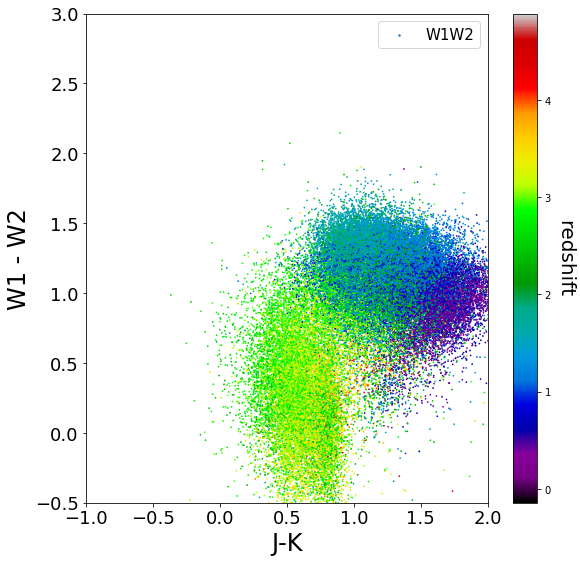

In [95]:
from matplotlib import pyplot as plt
plt.figure(figsize = (9,9))
graph = plt.scatter( test['JK'],test['W1W2'], s = 0.5, c = test['redshift_prediction'],cmap = plt.cm.nipy_spectral)


plt.xlim(-1,2)
plt.ylim(-0.5,3)
#plt.title('Targets for observations')
cb=plt.colorbar(graph)
cb.set_label('redshift', fontsize =20, rotation =-90, va='bottom')
ax = plt.axes()
ax.set_ylabel('W1 - W2', fontsize = 24)      
ax.set_xlabel('J-K', fontsize = 24)
ax.tick_params(axis='x', colors='k', labelsize=18)
ax.tick_params(axis='y', colors='k', labelsize=18)
plt.legend(fontsize = 15,markerscale=2)
#plt.savefig('targets_pm_qsos'+'.png', bbox_inches='tight', figsize=(5,5))

No handles with labels found to put in legend.


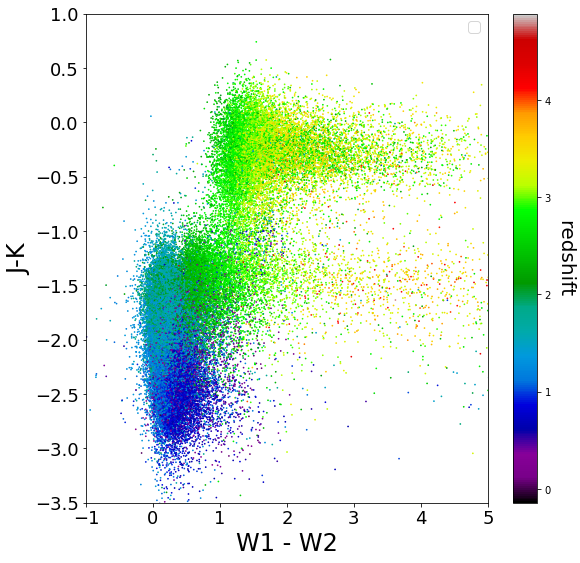

In [86]:
from matplotlib import pyplot as plt
plt.figure(figsize = (9,9))
graph = plt.scatter( test['ug'],test['W1mag']-test['hAperMag3'], s = 0.5, c = test['redshift_prediction'],cmap = plt.cm.nipy_spectral)


plt.xlim(-1,5)
plt.ylim(-3.5,1)
#plt.title('Targets for observations')
cb=plt.colorbar(graph)
cb.set_label('redshift', fontsize =20, rotation =-90, va='bottom')
ax = plt.axes()
ax.set_xlabel('W1 - W2', fontsize = 24)      
ax.set_ylabel('W1', fontsize = 24)
ax.tick_params(axis='x', colors='k', labelsize=18)
ax.tick_params(axis='y', colors='k', labelsize=18)
plt.legend(fontsize = 15,markerscale=2)
#plt.savefig('targets_pm_qsos'+'.png', bbox_inches='tight', figsize=(5,5))